In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
df_all_device  = pd.read_excel("./All_device_data_processed_20210126.xlsx", sheet_name= "Sheet1")
#print(df_all_device.columns)
df_all_device = df_all_device.iloc[:,2:12]
df_all_device = df_all_device.dropna()
df_all_device.columns = ['Temperature [\N{DEGREE SIGN}C]', 'Speed [mm/s]',
       'Spray Flow [uL/min]', 'Plamsa Height [cm]', 'Plasma Gas Flow [L/min]', 'Plasma DC [%]',
        'Jsc [mA/cm2]', 'Voc [V]', 'FF [-]', 'Efficiency [%]']
df_all_device

Index(['ML Condition', 'Sample', 'Temperature [°C]', 'Speed [mm/s]',
       'Spray Flow [uL/min]', 'Plamsa Height [cm]', 'Plasma Gas Flow [L/min]',
       'Plasma DC [%]', 'Jsc [mA/cm2]', 'Voc [V]', 'FF [-]', 'Efficiency [%]',
       'Film Success or not?', 'Unnamed: 13', ' ', 'Unnamed: 15',
       'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19',
       'Unnamed: 20', 'Unnamed: 21'],
      dtype='object')


,Temperature [°C],Speed [mm/s],Spray Flow [uL/min],Plamsa Height [cm],Plasma Gas Flow [L/min],Plasma DC [%],Jsc [mA/cm2],Voc [V],FF [-],Efficiency [%]
0,155,200,5000,1.2,35,50,16.261900,0.932514,0.39,5.914137
1,160,225,3000,0.8,30,75,2.239204,0.108900,0.25,0.060982
2,135,200,2500,1.0,25,75,23.176100,0.926920,0.60,12.889485
3,150,175,2000,1.0,20,100,20.804760,0.739500,0.31,4.769839
4,170,275,4500,1.2,16,50,21.509520,0.832600,0.66,11.820590
...,...,...,...,...,...,...,...,...,...,...
139,170,300,2500,1.0,25,100,15.171420,0.721700,0.39,4.270196
140,160,100,4000,1.0,25,75,15.428570,0.951900,0.49,7.196364
141,155,275,2500,1.2,35,100,5.652380,0.643600,0.43,1.564446
142,140,225,3000,1.0,20,50,21.495230,0.917800,0.72,14.204410


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler 

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from scipy.stats import spearmanr

X=df_all_device.iloc[:,:6]
y=df_all_device['Efficiency [%]']

X=X.to_numpy(dtype='float')
y=y.to_numpy(dtype='float').reshape(-1,1)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

scaler = StandardScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X = scaler.transform(X)

scaler_y = StandardScaler()
scaler_y.fit(y)
y_train = scaler_y.transform(y_train)
y_test = scaler_y.transform(y_test)
y = scaler_y.transform(y)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# Number of trees in random forest
n_estimators = [int(x) for x in np.arange(10,200,10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.arange(2,20,2)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# learning_rate 
learning_rate = np.arange(0.025,0.150,0.025)
# subsample 
subsample = np.arange(0.60, 0.95, 0.05) 
# 'reg_alpha':        
alpha = [1e-4, 1e-2, 0.1, 0.5, 0.99]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth, 
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'learning_rate': learning_rate,
               'subsample': subsample,
               'alpha': alpha}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
gb = GradientBoostingRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
gb_random = RandomizedSearchCV(estimator = gb, param_distributions = random_grid, 
                               n_iter = 1000, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
gb_random.fit(X_train, y_train)
best_params = gb_random.best_params_


In [110]:
#print(gb_random.best_params_)
best_params = {'subsample': 0.95, 
               'n_estimators': 105, 
               'min_samples_split': 2, 
               'min_samples_leaf': 2, 
               'max_features': 'sqrt',
               'max_depth': 4, 
               'learning_rate': 0.075,
               #'alpha':0.99
               }

In [109]:
from sklearn.ensemble import GradientBoostingRegressor
GBregressor_list = []
y_pred_list = []
y_train_pred_list = []
y_test_pred_list = []
for i in np.arange(100):
    GBregressor = GradientBoostingRegressor()
    GBregressor.set_params(**best_params)
    #GBregressor.fit(X_train, y_train.ravel())
    GBregressor.fit(X, y.ravel())

    GBregressor_list.append(GBregressor)
    
    y_train_pred=scaler_y.inverse_transform(GBregressor_list[i].predict(X_train).reshape(-1,1))
    y_test_pred=scaler_y.inverse_transform(GBregressor_list[i].predict(X_test).reshape(-1,1))
    y_pred=scaler_y.inverse_transform(GBregressor_list[i].predict(X).reshape(-1,1))
    y_train_pred_list.append(y_train_pred)
    y_test_pred_list.append(y_test_pred)
    y_pred_list.append(y_pred)
y_pred_mean = np.mean(y_pred_list, axis = 0)
y_train_pred_mean = np.mean(y_train_pred_list, axis = 0)
y_test_pred_mean = np.mean(y_test_pred_list, axis = 0)


ValueError: Invalid parameter alpha for estimator GradientBoostingClassifier(learning_rate=0.075, max_depth=4,
                           max_features='sqrt', min_samples_leaf=2,
                           n_estimators=105, subsample=0.95). Check the list of available parameters with `estimator.get_params().keys()`.

train rmse: 0.9614
test rmse: 1.2946
all rmse: 1.0377
train R^2: 0.9530
test R^2: 0.8941
all R^2: 0.9430
train spearman: 0.9316
test spearman: 0.9207
all spearman: 0.9307


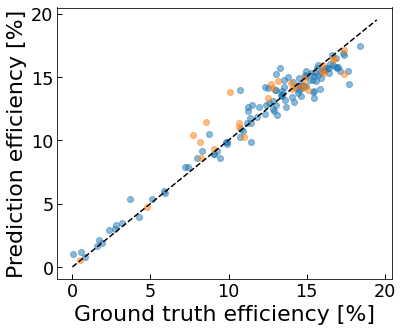

In [14]:
y_train_pred = y_train_pred_mean
y_test_pred = y_test_pred_mean
y_pred = y_pred_mean

from sklearn.metrics import mean_squared_error
mse = mean_squared_error
mse_train = mse(y_train_pred,scaler_y.inverse_transform(y_train))
mse_test = mse(y_test_pred,scaler_y.inverse_transform(y_test))
mse_all = mse(y_pred,scaler_y.inverse_transform(y))
print ('train rmse: %.4f' % (np.sqrt(mse_train)))
print ('test rmse: %.4f' % (np.sqrt(mse_test)))
print ('all rmse: %.4f' % (np.sqrt(mse_all)))


rsquared_train = r2_score(scaler_y.inverse_transform(y_train),y_train_pred)
rsquared_test = r2_score(scaler_y.inverse_transform(y_test), y_test_pred)
rsquared_all = r2_score(scaler_y.inverse_transform(y), y_pred)
print ('train R^2: %.4f' % (rsquared_train))
print ('test R^2: %.4f' % (rsquared_test))
print ('all R^2: %.4f' % (rsquared_all))

sprman_train = spearmanr(y_train_pred,scaler_y.inverse_transform(y_train))
sprman_test = spearmanr(y_test_pred,scaler_y.inverse_transform(y_test))
sprman_all = spearmanr(y_pred,scaler_y.inverse_transform(y))
print ('train spearman: %.4f' % (sprman_train[0]))
print ('test spearman: %.4f' % (sprman_test[0]))
print ('all spearman: %.4f' % (sprman_all[0]))

fs = 22
plt.figure(figsize=(6, 5))
plt.scatter(scaler_y.inverse_transform(y_train),y_train_pred, alpha =0.5)
plt.scatter(scaler_y.inverse_transform(y_test),y_test_pred, alpha =0.5)
#plt.scatter(y_scaled,y_pred, alpha =0.5)
yref = np.arange(0, 20, 0.5)
plt.plot(yref, yref, '--',color='black')
plt.xlabel('Ground truth efficiency [%]', fontsize = fs)
plt.ylabel('Prediction efficiency [%]', fontsize = fs)
plt.xticks([0, 5, 10, 15, 20])
#plt.title("Gradient Boosting")
plt.tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
#plt.savefig("Pervoskite Opt for Scale-up/Prelim_data_analysis/data_plots/RFR"+str(X1.name[:4])+".png",dpi=300)
plt.show()

In [15]:
## Total process conditions: 11x9x7x5x4x3 = 41580 conditions

temp_min, temp_max, temp_step = [125, 175, 5] ## Unit: degC ## 11 steps
temp_var = np.arange(temp_min, temp_max+temp_step, temp_step)
temp_num = len(temp_var)

speed_min, speed_max, speed_step = [100, 300, 25] ## Unit: mm/s ## 9 steps
speed_var = np.arange(speed_min, speed_max+speed_step, speed_step)
speed_num = len(speed_var)

sprayFL_min, sprayFL_max, sprayFL_step = [2000, 5000, 500] ## Unit: uL/min ## 7 steps
sprayFL_var = np.arange(sprayFL_min, sprayFL_max+sprayFL_step, sprayFL_step) 
sprayFL_num = len(sprayFL_var)

gasFL_min, gasFL_max, gasFL_step = [15, 35, 5] ## Unit: L/min ## 5 steps
gasFL_var = np.arange(gasFL_min, gasFL_max+gasFL_step, gasFL_step)
gasFL_num = len(gasFL_var)

plasmaDC_min, plasmaDC_max, plasmaDC_step = [25, 100, 25] # Unit: [%] ## 4 steps
plasmaDC_var = np.arange(plasmaDC_min, plasmaDC_max+plasmaDC_step, plasmaDC_step)
plasmaDC_num = len(plasmaDC_var)

plasmaH_min, plasmaH_max, plasmaH_step = [0.8, 1.2, 0.2] # Unit: cm ## 3 steps
plasmaH_var = np.arange(plasmaH_min, plasmaH_max+plasmaH_step, plasmaH_step)
plasmaH_num = len(plasmaH_var)


var_array = [temp_var, speed_var, 
             sprayFL_var, plasmaH_var, 
             gasFL_var, plasmaDC_var]
x_labels = ['Temperature [\N{DEGREE SIGN}C]', 
            'Speed [mm/s]',
            'Spray Flow [uL/min]', 
            'Plamsa Height [cm]', 
            'Plasma Gas Flow [L/min]', 
            'Plasma DC [%]']

In [16]:
def x_normalizer(X):
    
    def max_min_scaler(x, x_max, x_min):
        return (x-x_min)/(x_max-x_min)
    
    x_norm = []
    for x in (X):
           x_norm.append([max_min_scaler(x[i], 
                                         max(var_array[i]), 
                                         min(var_array[i])) for i in range(len(x))])  
    return np.array(x_norm)

def x_denormalizer(x_norm):
    def max_min_rescaler(x, x_max, x_min):
        return x*(x_max-x_min)+x_min
    
    x_original = []
    for x in (x_norm):
           x_original.append([max_min_rescaler(x[i], 
                                         max(var_array[i]), 
                                         min(var_array[i])) for i in range(len(x))])
    return np.array(x_original)



def get_closest_array(suggested_x):
    
    def get_closest_value(given_value, array_list):
        absolute_difference_function = lambda list_value : abs(list_value - given_value)
        closest_value = min(array_list, key=absolute_difference_function)
        return closest_value
    
    var_list = var_array
    modified_array = []
    for x in suggested_x:
        modified_array.append([get_closest_value(x[i], var_list[i]) for i in range(len(x))])
    return np.array(modified_array)

In [17]:
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.initial_designs.random_design import RandomDesign
from emukit.core.initial_designs.latin_design import LatinDesign

parameter_space = ParameterSpace([ContinuousParameter('temp', 0-1/(temp_num-1)/2, 1+1/(temp_num-1)/2),
                                 ContinuousParameter('speed', 0-1/(speed_num-1)/2, 1+1/(speed_num-1)/2),
                                 ContinuousParameter('sprayFL', 0-1/(sprayFL_num-1)/2, 1+1/(sprayFL_num-1)/2),
                                 ContinuousParameter('plamsaH', 0-1/(plasmaH_num-1)/2, 1+1/(plasmaH_num-1)/2),
                                 ContinuousParameter('gasFL', 0-1/(gasFL_num-1)/2, 1+1/(gasFL_num-1)/2),
                                 ContinuousParameter('plasmaDC', 0-1/(plasmaDC_num-1)/2, 1+1/(plasmaDC_num-1)/2)
                                 ])


parameter_space = ParameterSpace([ContinuousParameter('temp', 0,1),
                                 ContinuousParameter('speed', 0,1),
                                 ContinuousParameter('sprayFL', 0,1),
                                 ContinuousParameter('plamsaH', 0,1),
                                 ContinuousParameter('gasFL', 0,1),
                                 ContinuousParameter('plasmaDC', 0,1)
                                 ])

In [20]:
df_thiswork  = pd.read_excel("./All_device_data_processed_20210126.xlsx", sheet_name= "Sheet1")
df_thiswork = df_thiswork.iloc[:99,0:13]
thiswork_device = df_thiswork['Film Success or not?'] == 'Yes'

In [21]:
y_hat_list = []
for i in np.arange(len(GBregressor_list)):
    y_hat = GBregressor_list[i].predict(X[:99][thiswork_device])
    y_hat_list.append(y_hat)
y_hat_mean = np.mean(y_hat_list, axis = 0)

y_pred_thiswork_device = scaler_y.inverse_transform(y_hat_mean)
df_thiswork_device = df_thiswork.iloc[:99,2:8][thiswork_device].copy()
df_thiswork_device = df_thiswork_device.dropna()

max(y_pred_thiswork_device)
df_thiswork_device['Efficiency [%]'] = np.around(y_pred_thiswork_device,2)
df_thiswork_device.iloc[np.argmax(y_pred_thiswork_device):np.argmax(y_pred_thiswork_device)+1]
df_thiswork_device[df_thiswork_device['Efficiency [%]']>16]


,Temperature [°C],Speed [mm/s],Spray Flow [uL/min],Plamsa Height [cm],Plasma Gas Flow [L/min],Plasma DC [%],Efficiency [%]
70,140,200,4000,0.80,20,50,16.72
79,144,166,3270,1.15,19,44,17.11
82,149,170,3160,1.00,20,35,16.46
85,149,148,3120,1.00,18,37,16.92
89,141,134,3050,1.20,20,48,16.40
91,141,174,3010,1.00,16,42,16.37
95,140,150,3500,1.00,20,50,16.72


the rate of top 1 perc (>15%): 0.34


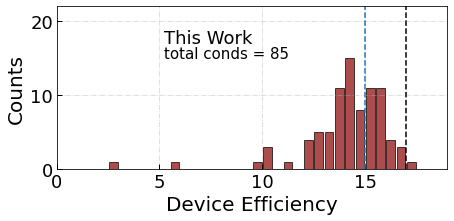

In [22]:
print("the rate of top 1 perc (>15%):", np.around (np.sum(df_thiswork_device.iloc[:,-1]>=15.04)/85, 2))
fs = 20
fig,axes = plt.subplots(1, 1, figsize=(7, 3), sharex = True)
axes.hist(df_thiswork_device.iloc[:,-1], bins= 40, range = (0, 20), 
             rwidth = 0.85, color = 'darkred', alpha = 0.7,
             edgecolor='k')####
axes.text(5.2, 17, 'This Work', fontsize=fs*0.9)
axes.text(5.2, 15, 'total conds = '+str(len(df_thiswork_device)), fontsize=15)
axes.tick_params(direction='in', length=5, width=1, labelsize = fs*.9, grid_alpha = 0.5)
axes.grid(True, linestyle='-.')
axes.set_ylabel('Counts', fontsize = fs)
axes.set_xlim(0, 19)
axes.set_ylim(0, 22)
#axes.set_yticks([0, 4, 8, 12])
axes.plot(np.ones(10)*15, np.linspace(0, 22, 10), '--')
axes.plot(np.ones(10)*17, np.linspace(0, 22, 10), '--', color = 'black')
axes.set_xlabel('Device Efficiency', fontsize = fs)

plt.show()

In [23]:
df_thiswork

,ML Condition,Sample,Temperature [°C],Speed [mm/s],Spray Flow [uL/min],Plamsa Height [cm],Plasma Gas Flow [L/min],Plasma DC [%],Jsc [mA/cm2],Voc [V],FF [-],Efficiency [%],Film Success or not?
0,0,B29R_3-FR0.dat,155,200,5000,1.2,35,50,16.261900,0.932514,0.39,5.914137,Yes
1,1,I3R,160,225,3000,0.8,30,75,2.239204,0.108900,0.25,0.060982,No
2,2,B18RPALE_4-FR0.dat,135,200,2500,1.0,25,75,23.176100,0.926920,0.60,12.889485,Yes
3,3,I2R,150,175,2000,1.0,20,100,20.804760,0.739500,0.31,4.769839,No
4,4,I6R,170,275,4500,1.2,16,50,21.509520,0.832600,0.66,11.820590,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,95,F7R.dat,140,150,3500,1.2,20,50,19.786000,1.021000,0.79,15.959000,Yes
95,96,F6R.dat,140,150,3500,1.0,20,50,18.933000,0.978000,0.58,10.739000,Yes
96,97,F24R.dat,145,125,3000,1.2,16,50,22.752000,0.987000,0.74,16.621000,Yes
97,98,F42L.dat,150,175,3500,1.0,16,50,26.433000,0.978000,0.58,14.988000,Yes


### One Variable at a Time 

In [36]:
x_current_best = [np.ones(6)*0.5]
for xx in variable_list[v]:
    x_temp = x_current_best[0]
    x_temp[v] = xx
    x_ovat.append(x_temp.copy())
#random.shuffle(x_ovat)
x_ovat_original = x_denormalizer(x_ovat)
df_ovat = pd.DataFrame(x_ovat_original, columns = x_labels)
# model prediction with regressor
y_hat_list = []
for i in np.arange(len(GBregressor_list)):
    y_hat = GBregressor_list[i].predict(scaler.transform(x_ovat_original))
    y_hat_list.append(y_hat)
y_hat_mean = np.mean(y_hat_list, axis = 0)
y_pred_ovat = scaler_y.inverse_transform(y_hat_mean)

# Sort and find the best conditions
df_ovat['Efficiency [%]'] = np.around(y_pred_ovat, 2)
df_ovat= df_ovat.drop_duplicates(keep = 'last', ignore_index = True)    

df_ovat

,Temperature [°C],Speed [mm/s],Spray Flow [uL/min],Plamsa Height [cm],Plasma Gas Flow [L/min],Plasma DC [%],Efficiency [%]
0,155.0,100.0,5000.0,0.8,35.0,100.0,3.63
1,155.0,125.0,5000.0,0.8,35.0,100.0,5.94
2,155.0,150.0,5000.0,0.8,35.0,100.0,5.74
3,155.0,200.0,5000.0,0.8,35.0,100.0,5.53
4,155.0,225.0,5000.0,0.8,35.0,100.0,5.59
5,155.0,250.0,5000.0,0.8,35.0,100.0,6.02
6,155.0,275.0,5000.0,0.8,35.0,100.0,6.07
7,155.0,300.0,5000.0,0.8,35.0,100.0,6.03
8,155.0,175.0,2000.0,0.8,35.0,100.0,0.51
9,155.0,175.0,2500.0,0.8,35.0,100.0,0.68


In [103]:
import random
variable_list = [np.linspace(0, 1, temp_num),
                 np.linspace(0, 1, speed_num),
                 np.linspace(0, 1, sprayFL_num),
                 np.linspace(0, 1, plasmaH_num),
                 np.linspace(0, 1, gasFL_num),
                 np.linspace(0, 1, plasmaDC_num)]


convglen_list = []
convgeff_list = []
ovat_df_list = []
conv_batch_list = []

for m in range(100):
    x_ovat = []
    len_x_ovat = 0
    x_current_best = [np.ones(6)*0.5]
    n2 = 0
    #Generate a random initial condition
    for var_indx in np.arange(6):
        level_num = len(variable_list[var_indx])
        level_indx = np.random.randint(0, level_num, 1)[0]
        x_current_best[0][var_indx] =  variable_list[var_indx][level_indx]

    for n in range(20):
        
        var_indx_array = np.arange(6)
        random.shuffle(var_indx_array)#randomized which variable to start
        for v in var_indx_array:
            # generate a batch of new conditions
            for xx in variable_list[v]:
                x_temp = x_current_best[0]
                x_temp[v] = xx
                x_ovat.append(x_temp.copy())
            #random.shuffle(x_ovat)
            x_ovat_original = x_denormalizer(x_ovat)
            df_ovat = pd.DataFrame(x_ovat_original, columns = x_labels)
            
            # model prediction with regressor
            y_hat_list = []
            for i in np.arange(len(GBregressor_list)):
                y_hat = GBregressor_list[i].predict(scaler.transform(x_ovat_original))
                y_hat_list.append(y_hat)
            y_hat_mean = np.mean(y_hat_list, axis = 0)
            y_pred_ovat = scaler_y.inverse_transform(y_hat_mean)
            
            # Sort and find the best conditions
            df_ovat['Efficiency [%]'] = np.around(y_pred_ovat, 2)
            df_ovat= df_ovat.drop_duplicates(keep = 'last', ignore_index = True)
            x_current_best = x_normalizer([df_ovat.iloc[np.argmax(df_ovat['Efficiency [%]'].values)].values[:-1]])
            #print(np.max(df_ovat['Efficiency [%]']))
            #print(x_current_best)

        if len_x_ovat<len(df_ovat):
            len_x_ovat = len(df_ovat)
        elif n2 <= 4:
            n2 = n2+2
            variable_list = [np.linspace(0, 1, temp_num*n2),
                 np.linspace(0, 1, speed_num*n2),
                 np.linspace(0, 1, sprayFL_num*n2),
                 np.linspace(0, 1, plasmaH_num*n2),
                 np.linspace(0, 1, gasFL_num*n2),
                 np.linspace(0, 1, plasmaDC_num*n2)]

        if len(df_ovat)>=300:
            break
            print('number of experiments:', len_x_ovat)
            print(np.max(df_ovat['Efficiency [%]']))
            

       
    #print('no more new conditions; so, random seeding')
    print('number of experiments:', len_x_ovat)
    print(np.max(df_ovat['Efficiency [%]']))
    print('batch', n*6)#number of batch - one variable per batch (with specified intevals)
    convglen_list.append(len_x_ovat)
    convgeff_list.append(np.max(df_ovat['Efficiency [%]']))
    ovat_df_list.append(df_ovat)
    conv_batch_list.append(n*6)
    
    
#     fs = 20
#     fig,axes = plt.subplots(1, 1, figsize=(7, 3), sharex = True)
#     hist_data = axes.hist(df_ovat.iloc[:,-1], bins= 40, range = (0, 20), 
#                  rwidth = 0.85, color = 'darkred', alpha = 0.7,
#                  edgecolor='k')####

#     axes.text(2.2, max(hist_data[0])*.9, 'One Var at a Time', fontsize=fs*0.9)
#     axes.text(2.2, max(hist_data[0])*.8, 'total conds = '+str(len(df_ovat)), fontsize=15)
#     axes.tick_params(direction='in', length=5, width=1, labelsize = fs*.9, grid_alpha = 0.5)
#     axes.grid(True, linestyle='-.')
#     axes.set_ylabel('Counts', fontsize = fs)
#     axes.set_xlim(0, 19)
#     axes.set_ylim(0, max(hist_data[0])*1.1)
#     #axes.set_yticks([0, 4, 8, 12])
#     axes.plot(np.ones(10)*15, np.linspace(0, max(hist_data[0])*1.1, 10), '--')
#     axes.plot(np.ones(10)*17, np.linspace(0, max(hist_data[0])*1.1, 10), '--', color = 'black')
#     axes.set_xlabel('Device Efficiency', fontsize = fs)

#     plt.show()
    
    print(x_normalizer([df_ovat.iloc[np.argmax(df_ovat['Efficiency [%]'].values)].values[:-1]]))
    df_ovat.iloc[np.argmax(df_ovat['Efficiency [%]'].values):np.argmax(df_ovat['Efficiency [%]'].values)+1]

number of experiments: 326
17.12
batch 54
[[0.4        0.11764706 0.33333333 1.         0.         0.        ]]
number of experiments: 361
17.55
batch 30
[[0.38095238 0.14285714 0.33333333 1.         0.         0.06666667]]
number of experiments: 301
17.66
batch 6
[[0.37209302 0.4        0.48148148 0.63636364 0.05263158 0.06666667]]
number of experiments: 420
17.66
batch 12
[[0.34883721 0.42857143 0.48148148 0.63636364 0.         0.06666667]]
number of experiments: 300
17.67
batch 6
[[0.39534884 0.42857143 0.48148148 0.63636364 0.         0.06666667]]
number of experiments: 420
17.67
batch 12
[[0.39534884 0.4        0.48148148 0.63636364 0.05263158 0.06666667]]
number of experiments: 301
17.67
batch 6
[[0.39534884 0.4        0.48148148 0.63636364 0.         0.06666667]]
number of experiments: 421
17.55
batch 12
[[0.41860465 0.14285714 0.33333333 1.         0.         0.06666667]]
number of experiments: 301
17.55
batch 6
[[0.34883721 0.4        0.48148148 1.         0.05263158 0.0666666

number of experiments: 301
17.67
batch 6
[[0.39534884 0.4        0.48148148 0.63636364 0.         0.06666667]]
number of experiments: 300
16.99
batch 6
[[0.34883721 0.4        0.48148148 0.         0.21052632 0.06666667]]
number of experiments: 389
17.67
batch 12
[[0.39534884 0.4        0.48148148 0.63636364 0.         0.06666667]]
number of experiments: 301
17.4
batch 6
[[0.34883721 0.14285714 0.37037037 1.         0.         0.06666667]]
number of experiments: 301
17.67
batch 6
[[0.39534884 0.4        0.48148148 0.63636364 0.05263158 0.06666667]]
number of experiments: 405
17.67
batch 12
[[0.39534884 0.42857143 0.48148148 0.63636364 0.         0.06666667]]
number of experiments: 301
17.47
batch 6
[[0.37209302 0.4        0.48148148 0.63636364 0.21052632 0.06666667]]
number of experiments: 301
17.67
batch 6
[[0.39534884 0.42857143 0.48148148 0.63636364 0.         0.06666667]]
number of experiments: 381
17.48
batch 12
[[0.34883721 0.14285714 0.33333333 1.         0.         0.06666667]]

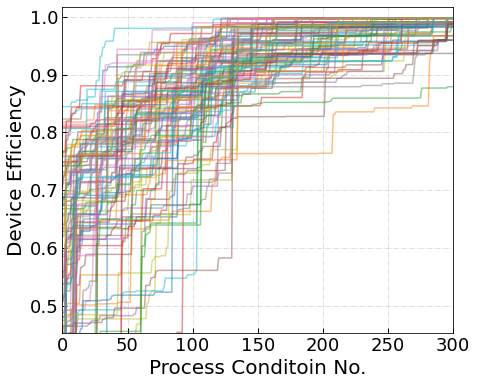

In [105]:
eff_max = 17.7
fs = 20
fig,axes = plt.subplots(1, 1, figsize=(7, 6), sharex = True)
ax = axes
for df_i in ovat_df_list:
    eff_max_acc = np.maximum.accumulate(df_i.iloc[:,-1])
    eff_acc = df_i.iloc[:,-1]
    ax.plot(range(len(eff_max_acc)),eff_max_acc/eff_max, alpha = 0.5)
#plt.scatter(range(len(eff_max_acc)),eff_acc)

# axes.text(80, 9, 'One Var at at Time', fontsize=fs*0.9)
# axes.text(80, 8, 'total conds = '+str(len(convglen_list)), fontsize=15)
axes.tick_params(direction='in', length=5, width=1, labelsize = fs*.9, grid_alpha = 0.5)
axes.set_ylim(8/eff_max,18/eff_max)
axes.set_xlim(0,300)

axes.grid(True, linestyle='-.')
axes.set_ylabel('Device Efficiency', fontsize = fs)
axes.set_xlabel('Process Conditoin No.', fontsize = fs)
plt.show()

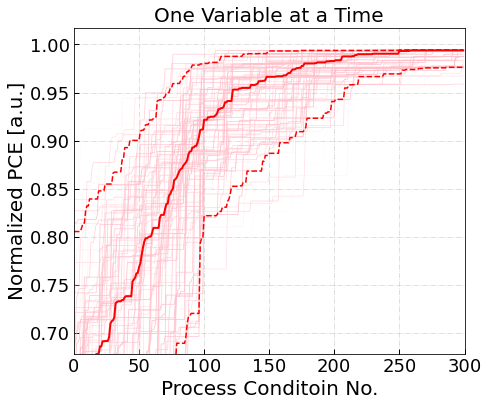

In [108]:
max_eff =17.7
fs = 20
fig,axes = plt.subplots(1, 1, figsize=(7, 6), sharex = True)
ax = axes
i = 0
eff_max_runlist = []
for df_i in OneVarAtTime_list:
    eff_max_acc = np.maximum.accumulate(df_i)
    eff_acc = df_i
    i = i +1
    ax.plot(range(len(eff_max_acc)),eff_max_acc/max_eff, alpha = 0.8*i/len(OneVarAtTime_list)+0.4, c = 'pink', linewidth=0.75)
    eff_max_runlist.append(eff_max_acc/max_eff)
#plt.scatter(range(len(eff_max_acc)),eff_acc)
line_95perc = np.percentile(eff_max_runlist, 95, axis = 0)
line_median = np.percentile(eff_max_runlist, 50, axis = 0)
line_5perc = np.percentile(eff_max_runlist, 5, axis = 0)

ax.plot(line_95perc,'--', c = 'red', linewidth=1.5)
ax.plot(line_median,'-', c = 'red', linewidth=2)
ax.plot(line_5perc,'--', c = 'red', linewidth=1.5)

#axes.text(80, 9, 'One Var at at Time', fontsize=fs*0.9)
#axes.text(80, 8, 'total conds = '+str(len(convglen_list)), fontsize=15)
axes.tick_params(direction='in', length=5, width=1, labelsize = fs*.9, grid_alpha = 0.5)
axes.set_ylim(12/max_eff,18/max_eff)
axes.set_xlim(0,300)

axes.grid(True, linestyle='-.')
axes.set_ylabel('Normalized PCE [a.u.]', fontsize = fs)
axes.set_xlabel('Process Conditoin No.', fontsize = fs)
axes.set_title('One Variable at a Time', fontsize = fs)
plt.show()

LHS_full_5perc, LHS_full_50perc, LHS_full_95perc= [line_5perc, line_median, line_95perc]

In [95]:
OneVarAtTime_list_df = pd.DataFrame(np.transpose(OneVarAtTime_list))
OneVarAtTime_list_df.to_excel("OneVarAtTime_list_benckmark_20210701.xls")
OneVarAtTime_list_df

<ipython-input-95-76f45fdc5dcc>:2: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  OneVarAtTime_list_df.to_excel("OneVarAtTime_list_benckmark_20210701.xls")


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,7.76,6.75,10.85,14.85,14.41,2.76,6.93,3.97,1.70,13.69,...,12.02,7.40,10.70,11.93,11.73,9.76,4.65,11.00,13.11,8.26
1,7.91,6.76,11.19,14.59,13.99,2.76,7.20,3.97,1.70,13.40,...,12.03,7.42,10.70,11.66,11.38,9.55,4.85,11.01,13.11,8.26
2,7.75,7.28,11.33,14.84,13.91,4.71,6.78,5.12,3.27,13.50,...,12.56,7.81,11.51,11.50,11.36,10.68,5.81,11.43,13.92,9.28
3,7.93,7.29,11.34,14.56,13.31,4.66,6.70,5.12,3.27,13.20,...,12.56,7.81,11.51,11.68,11.24,10.72,6.47,11.43,13.86,9.28
4,6.57,7.73,11.54,14.56,13.31,3.47,6.99,5.18,3.29,13.20,...,12.55,7.81,11.58,11.68,11.22,10.82,6.50,11.42,13.27,9.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,13.45,15.89,15.02,15.78,14.85,14.17,17.05,14.76,16.96,14.43,...,16.78,17.53,15.06,17.05,15.66,15.66,16.79,16.81,17.48,17.59
296,13.49,15.88,17.37,15.79,14.74,14.26,16.82,14.79,17.02,14.43,...,16.47,17.42,15.06,17.60,14.43,15.66,17.60,15.06,16.45,17.60
297,13.43,15.87,17.60,14.87,14.72,16.10,16.81,10.95,17.03,14.42,...,16.69,17.49,15.04,17.59,14.43,14.43,17.53,15.06,16.45,17.38
298,13.41,17.27,16.79,14.52,14.46,16.10,15.06,10.95,17.59,14.84,...,16.69,10.95,15.37,15.66,14.42,14.43,17.42,15.04,16.95,17.04


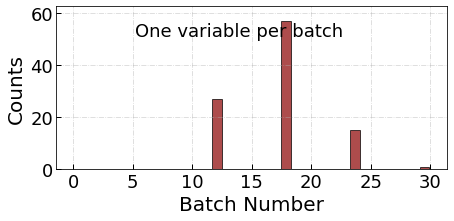

In [101]:
fs = 20
fig,axes = plt.subplots(1, 1, figsize=(7, 3), sharex = True)
hist_data = axes.hist(np.array(conv_batch_list)*6, bins= 31, range = (0, 30), 
             rwidth = 0.85, color = 'darkred', alpha = 0.7,
             edgecolor='k')####

axes.text(5.2, max(hist_data[0])*.9, 'One variable per batch', fontsize=fs*0.9)
#axes.text(5.2, max(hist_data[0])*.8, 'total conds = '+str(len(conv_batch_list)), fontsize=15)
axes.tick_params(direction='in', length=5, width=1, labelsize = fs*.9, grid_alpha = 0.5)
axes.grid(True, linestyle='-.')
axes.set_ylabel('Counts', fontsize = fs)
#axes.set_xlim(0, 19)
axes.set_ylim(0, max(hist_data[0])*1.1)
#axes.set_yticks([0, 4, 8, 12])
axes.set_xlabel('Batch Number', fontsize = fs)

plt.show()

### One Variable at a Time (Batch - 20/19, run all six variables in two batch)

In [39]:
import random
variable_list = [np.linspace(0, 1, temp_num),
                 np.linspace(0, 1, speed_num),
                 np.linspace(0, 1, sprayFL_num),
                 np.linspace(0, 1, plasmaH_num),
                 np.linspace(0, 1, gasFL_num),
                 np.linspace(0, 1, plasmaDC_num)]

convglen_list = []
convgeff_list = []
ovat_df_list = []
conv_batch_list= []
for m in range(1):
#    print(m)
    x_ovat = []
    len_x_ovat = 0
    x_current_best = [np.ones(6)]
    for var_indx in np.arange(6):
        level_num = len(variable_list[var_indx])
        level_indx = np.random.randint(0, level_num, 1)[0]
        x_current_best[0][var_indx] =  variable_list[var_indx][level_indx]

    for n in range(20):
        
        first_batch, second_batch = [[0,1], [2,3,4,5]]  
        var_indx_array = first_batch
        random.shuffle(var_indx_array)
        for v in var_indx_array:
            for xx in variable_list[v]:
                x_temp = x_current_best[0]
                x_temp[v] = xx
                x_ovat.append(x_temp.copy())
            #random.shuffle(x_ovat)
            x_ovat_original = x_denormalizer(x_ovat)
            df_ovat = pd.DataFrame(x_ovat_original, columns = x_labels)

            y_hat_list = []
            for i in np.arange(len(GBregressor_list)):
                y_hat = GBregressor_list[i].predict(scaler.transform(x_ovat_original))
                y_hat_list.append(y_hat)
            y_hat_mean = np.mean(y_hat_list, axis = 0)
            y_pred_ovat = scaler_y.inverse_transform(y_hat_mean)
        # Only check the best conditions after all
        df_ovat['Efficiency [%]'] = np.around(y_pred_ovat, 2)
        df_ovat= df_ovat.drop_duplicates(keep = 'last', ignore_index = True)
        x_current_best = x_normalizer([df_ovat.iloc[np.argmax(df_ovat['Efficiency [%]'].values)].values[:-1]])
        
        if len_x_ovat<len(df_ovat):
            len_x_ovat = len(df_ovat)
            #print('number of experiments:', len_x_ovat)
        else:
            #print('no more new conditions; so, random seeding')
            print('number of experiments:', len_x_ovat)
            print(np.max(df_ovat['Efficiency [%]']))
            print('batch number', 2*(n-1))
            convglen_list.append(len_x_ovat)
            convgeff_list.append(np.max(df_ovat['Efficiency [%]']))
            ovat_df_list.append(df_ovat)
            conv_batch_list.append(2*(n-1))
            break
        
        var_indx_array = second_batch
        random.shuffle(var_indx_array)
        for v in var_indx_array:
            for xx in variable_list[v]:
                x_temp = x_current_best[0]
                x_temp[v] = xx
                x_ovat.append(x_temp.copy())
            #random.shuffle(x_ovat)
            x_ovat_original = x_denormalizer(x_ovat)
            df_ovat = pd.DataFrame(x_ovat_original, columns = x_labels)

            y_hat_list = []
            for i in np.arange(len(GBregressor_list)):
                y_hat = GBregressor_list[i].predict(scaler.transform(x_ovat_original))
                y_hat_list.append(y_hat)
            y_hat_mean = np.mean(y_hat_list, axis = 0)
            y_pred_ovat = scaler_y.inverse_transform(y_hat_mean)
        # Only check the best conditions after all
        df_ovat['Efficiency [%]'] = np.around(y_pred_ovat, 2)
        df_ovat= df_ovat.drop_duplicates(keep = 'last', ignore_index = True)
        x_current_best = x_normalizer([df_ovat.iloc[np.argmax(df_ovat['Efficiency [%]'].values)].values[:-1]])

        if len_x_ovat<len(df_ovat):
            len_x_ovat = len(df_ovat)
            #print('number of experiments:', len_x_ovat)
        else:
            #print('no more new conditions; so, random seeding')
            print('number of experiments:', len_x_ovat)
            print(np.max(df_ovat['Efficiency [%]']))
            print('batch number', 2*(n-1)+1)
            convglen_list.append(len_x_ovat)
            convgeff_list.append(np.max(df_ovat['Efficiency [%]']))
            ovat_df_list.append(df_ovat)
            conv_batch_list.append(2*(n-1)+1)

            break

#     fs = 20
#     fig,axes = plt.subplots(1, 1, figsize=(7, 3), sharex = True)
#     hist_data = axes.hist(df_ovat.iloc[:,-1], bins= 40, range = (0, 20), 
#                  rwidth = 0.85, color = 'darkred', alpha = 0.7,
#                  edgecolor='k')####

#     axes.text(2.2, max(hist_data[0])*.9, 'One Var at a Time', fontsize=fs*0.9)
#     axes.text(2.2, max(hist_data[0])*.8, 'total conds = '+str(len(df_ovat)), fontsize=15)
#     axes.tick_params(direction='in', length=5, width=1, labelsize = fs*.9, grid_alpha = 0.5)
#     axes.grid(True, linestyle='-.')
#     axes.set_ylabel('Counts', fontsize = fs)
#     axes.set_xlim(0, 19)
#     axes.set_ylim(0, max(hist_data[0])*1.1)
#     #axes.set_yticks([0, 4, 8, 12])
#     axes.plot(np.ones(10)*15, np.linspace(0, max(hist_data[0])*1.1, 10), '--')
#     axes.plot(np.ones(10)*17, np.linspace(0, max(hist_data[0])*1.1, 10), '--', color = 'black')
#     axes.set_xlabel('Device Efficiency', fontsize = fs)

#     plt.show()

#     print(x_normalizer([df_ovat.iloc[np.argmax(df_ovat['Efficiency [%]'].values)].values[:-1]]))
    df_ovat.iloc[np.argmax(df_ovat['Efficiency [%]'].values):np.argmax(df_ovat['Efficiency [%]'].values)+1]

number of experiments: 86
16.16
batch number 4


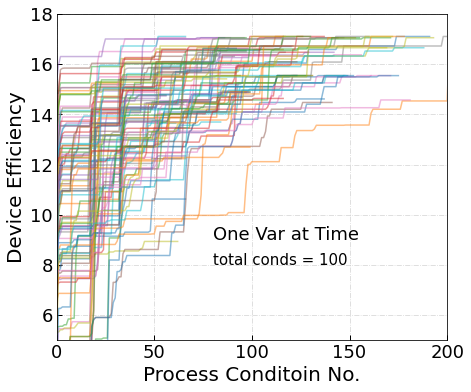

In [108]:
fs = 20
fig,axes = plt.subplots(1, 1, figsize=(7, 6), sharex = True)
ax = axes
for df_i in ovat_df_list:
    eff_max_acc = np.maximum.accumulate(df_i.iloc[:,-1])
    eff_acc = df_i.iloc[:,-1]
    ax.plot(range(len(eff_max_acc)),eff_max_acc, alpha = 0.5)
#plt.scatter(range(len(eff_max_acc)),eff_acc)

axes.text(80, 9, 'One Var at Time', fontsize=fs*0.9)
axes.text(80, 8, 'total conds = '+str(len(convglen_list)), fontsize=15)
axes.tick_params(direction='in', length=5, width=1, labelsize = fs*.9, grid_alpha = 0.5)
axes.set_ylim(5,18)
axes.set_xlim(0,200)

axes.grid(True, linestyle='-.')
axes.set_ylabel('Device Efficiency', fontsize = fs)
axes.set_xlabel('Process Conditoin No.', fontsize = fs)
plt.show()

In [103]:
import random
variable_list = [np.linspace(0, 1, temp_num),
                 np.linspace(0, 1, speed_num),
                 np.linspace(0, 1, sprayFL_num),
                 np.linspace(0, 1, plasmaH_num),
                 np.linspace(0, 1, gasFL_num),
                 np.linspace(0, 1, plasmaDC_num)]
def two_batch_gen(variable_list):
    for x in range(10):
        var_len = [len(var) for var in variable_list]
        var_indx = [0, 1, 2, 3, 4, 5]
        indx_seq_list = []
        indx_remain_list = var_indx.copy()
        for i in range(10):
            v = np.random.randint(0, len(indx_remain_list), 1)[0]
            indx = indx_remain_list[v]
            indx_seq_list.append(indx)
            indx_remain_list.remove(indx)
            batch_size = np.sum([var_len[i] for i in indx_seq_list])
            if batch_size > 20:
                indx_remain_list.append(indx)
                indx_seq_list.remove(indx)
                first_batch_size = np.sum([var_len[i] for i in indx_seq_list])
                second_batch_size = np.sum([var_len[i] for i in indx_remain_list])
        if first_batch_size >=17:
            first_batch = indx_seq_list
            second_batch = indx_remain_list
            #print(first_batch, second_batch)
            break 
    return first_batch, second_batch

convglen_list = []
convgeff_list = []
ovat_df_list = []
conv_batch_list= []
for m in range(100):
    print(m)
    x_ovat = []
    len_x_ovat = 0
    x_current_best = [np.ones(6)]
    for var_indx in np.arange(6):
        level_num = len(variable_list[var_indx])
        level_indx = np.random.randint(0, level_num, 1)[0]
        x_current_best[0][var_indx] =  variable_list[var_indx][level_indx]

    for n in range(20):
        
        first_batch, second_batch = two_batch_gen(variable_list)     
        var_indx_array = first_batch
        random.shuffle(var_indx_array)
        for v in var_indx_array:
            for xx in variable_list[v]:
                x_temp = x_current_best[0]
                x_temp[v] = xx
                x_ovat.append(x_temp.copy())
            #random.shuffle(x_ovat)
            x_ovat_original = x_denormalizer(x_ovat)
            df_ovat = pd.DataFrame(x_ovat_original, columns = x_labels)

            y_hat_list = []
            for i in np.arange(len(GBregressor_list)):
                y_hat = GBregressor_list[i].predict(scaler.transform(x_ovat_original))
                y_hat_list.append(y_hat)
            y_hat_mean = np.mean(y_hat_list, axis = 0)
            y_pred_ovat = scaler_y.inverse_transform(y_hat_mean)
        # Only check the best conditions after all
        df_ovat['Efficiency [%]'] = np.around(y_pred_ovat, 2)
        df_ovat= df_ovat.drop_duplicates(keep = 'last', ignore_index = True)
        x_current_best = x_normalizer([df_ovat.iloc[np.argmax(df_ovat['Efficiency [%]'].values)].values[:-1]])
        
        if len_x_ovat<len(df_ovat):
            len_x_ovat = len(df_ovat)
            #print('number of experiments:', len_x_ovat)
        else:
            #print('no more new conditions; so, random seeding')
            print('number of experiments:', len_x_ovat)
            print(np.max(df_ovat['Efficiency [%]']))
            print('batch number', 2*(n-1))
            convglen_list.append(len_x_ovat)
            convgeff_list.append(np.max(df_ovat['Efficiency [%]']))
            ovat_df_list.append(df_ovat)
            conv_batch_list.append(2*(n-1))
            break
        
        var_indx_array = second_batch
        random.shuffle(var_indx_array)
        for v in var_indx_array:
            for xx in variable_list[v]:
                x_temp = x_current_best[0]
                x_temp[v] = xx
                x_ovat.append(x_temp.copy())
            #random.shuffle(x_ovat)
            x_ovat_original = x_denormalizer(x_ovat)
            df_ovat = pd.DataFrame(x_ovat_original, columns = x_labels)

            y_hat_list = []
            for i in np.arange(len(GBregressor_list)):
                y_hat = GBregressor_list[i].predict(scaler.transform(x_ovat_original))
                y_hat_list.append(y_hat)
            y_hat_mean = np.mean(y_hat_list, axis = 0)
            y_pred_ovat = scaler_y.inverse_transform(y_hat_mean)
        # Only check the best conditions after all
        df_ovat['Efficiency [%]'] = np.around(y_pred_ovat, 2)
        df_ovat= df_ovat.drop_duplicates(keep = 'last', ignore_index = True)
        x_current_best = x_normalizer([df_ovat.iloc[np.argmax(df_ovat['Efficiency [%]'].values)].values[:-1]])

        if len_x_ovat<len(df_ovat):
            len_x_ovat = len(df_ovat)
            #print('number of experiments:', len_x_ovat)
        else:
            #print('no more new conditions; so, random seeding')
            print('number of experiments:', len_x_ovat)
            print(np.max(df_ovat['Efficiency [%]']))
            print('batch number', 2*(n-1)+1)
            convglen_list.append(len_x_ovat)
            convgeff_list.append(np.max(df_ovat['Efficiency [%]']))
            ovat_df_list.append(df_ovat)
            conv_batch_list.append(2*(n-1)+1)

            break

#     fs = 20
#     fig,axes = plt.subplots(1, 1, figsize=(7, 3), sharex = True)
#     hist_data = axes.hist(df_ovat.iloc[:,-1], bins= 40, range = (0, 20), 
#                  rwidth = 0.85, color = 'darkred', alpha = 0.7,
#                  edgecolor='k')####

#     axes.text(2.2, max(hist_data[0])*.9, 'One Var at a Time', fontsize=fs*0.9)
#     axes.text(2.2, max(hist_data[0])*.8, 'total conds = '+str(len(df_ovat)), fontsize=15)
#     axes.tick_params(direction='in', length=5, width=1, labelsize = fs*.9, grid_alpha = 0.5)
#     axes.grid(True, linestyle='-.')
#     axes.set_ylabel('Counts', fontsize = fs)
#     axes.set_xlim(0, 19)
#     axes.set_ylim(0, max(hist_data[0])*1.1)
#     #axes.set_yticks([0, 4, 8, 12])
#     axes.plot(np.ones(10)*15, np.linspace(0, max(hist_data[0])*1.1, 10), '--')
#     axes.plot(np.ones(10)*17, np.linspace(0, max(hist_data[0])*1.1, 10), '--', color = 'black')
#     axes.set_xlabel('Device Efficiency', fontsize = fs)

#     plt.show()

#     print(x_normalizer([df_ovat.iloc[np.argmax(df_ovat['Efficiency [%]'].values)].values[:-1]]))
    df_ovat.iloc[np.argmax(df_ovat['Efficiency [%]'].values):np.argmax(df_ovat['Efficiency [%]'].values)+1]

0
number of experiments: 203
16.48
batch number 11
1
number of experiments: 316
16.48
batch number 27
2
number of experiments: 229
16.48
batch number 15
3
number of experiments: 247
17.11
batch number 17
4
number of experiments: 178
15.55
batch number 13
5
number of experiments: 188
16.18
batch number 11
6
number of experiments: 84
14.54
batch number 5
7
number of experiments: 152
15.87
batch number 9
8
number of experiments: 202
16.63
batch number 13
9
number of experiments: 227
17.06
batch number 17
10
number of experiments: 235
17.06
batch number 15
11
number of experiments: 361
17.06
batch number 25
12
number of experiments: 111
15.55
batch number 5
13
number of experiments: 216
16.18
batch number 13
14
number of experiments: 281
17.06
batch number 23
15
number of experiments: 132
15.55
batch number 9
16
number of experiments: 149
14.88
batch number 11
17
number of experiments: 105
15.68
batch number 5
18
number of experiments: 204
16.35
batch number 13
19
number of experiments: 17

NameError: name 'ovat_df_list' is not defined

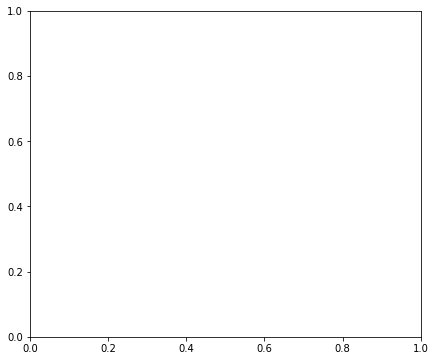

In [190]:
fs = 20
fig,axes = plt.subplots(1, 1, figsize=(7, 6), sharex = True)
ax = axes
for df_i in ovat_df_list:
    eff_max_acc = np.maximum.accumulate(df_i.iloc[:,-1])
    eff_acc = df_i.iloc[:,-1]
    ax.plot(range(len(eff_max_acc)),eff_max_acc, alpha = 0.5)
#plt.scatter(range(len(eff_max_acc)),eff_acc)

axes.text(80, 9, 'One Var at at Time', fontsize=fs*0.9)
axes.text(80, 8, 'total conds = '+str(len(convglen_list)), fontsize=15)
axes.tick_params(direction='in', length=5, width=1, labelsize = fs*.9, grid_alpha = 0.5)
axes.set_ylim(5,18)
axes.set_xlim(0,200)

axes.grid(True, linestyle='-.')
axes.set_ylabel('Device Efficiency', fontsize = fs)
axes.set_xlabel('Process Conditoin No.', fontsize = fs)
plt.show()

### Plot CPF for efficiency

In [127]:
# design = RandomDesign(parameter_space)
# random_cnt_list = []
# random_cum_list = []
# random_effmax_seq_list = []
# for i in np.arange(200):
#     design = RandomDesign(parameter_space)
#     x_random = design.get_samples(1000)
#     #x_random_original = get_closest_array(x_denormalizer(x_random))
#     x_random_original = x_denormalizer(x_random)
#     df_random = pd.DataFrame(x_random_original, columns = x_labels)
#     y_pred_random = scaler_y.inverse_transform(GBregressor.predict(scaler.transform(x_random_original)))
#     df_random['Efficiency [%]'] = np.around(y_pred_random, 2)
    
#     eff_seq= df_random.iloc[:,-1].values
#     eff_sorted = np.sort(eff_seq)
#     effmax_seq = np.maximum.accumulate(eff_seq)

#     cnts, bins = np.histogram(eff_sorted, bins=np.arange(21))
#     cum_cnts = np.cumsum(cnts)
#     x = bins[:-1]+0.5
#     y_cnt = cnts/cum_cnts[-1]
#     y_cum = cum_cnts/cum_cnts[-1]
#     random_cnt_list.append(y_cnt)
#     random_cum_list.append(y_cum)
#     random_effmax_seq_list.append(effmax_seq)
    
# random_effmax_seq_max = np.quantile(random_effmax_seq_list, 0.975, axis = 0)
# random_effmax_seq_min = np.quantile(random_effmax_seq_list, 0.025, axis = 0)
# random_effmax_seq_mean = np.mean(random_effmax_seq_list, axis = 0)

# random_distr_max = np.quantile(random_cnt_list, 0.975, axis = 0)
# random_distr_min = np.quantile(random_cnt_list, 0.025, axis = 0)
# random_distr_mean = np.mean(random_cnt_list, axis = 0)
    
# random_cum_distr_max = np.quantile(random_cum_list, 0.975, axis = 0)
# random_cum_distr_min = np.quantile(random_cum_list, 0.025, axis = 0)
# random_cum_distr_mean = np.mean(random_cum_list, axis = 0)

lhs_cum_list = []
lhs_cnt_list = []
lhs_effmax_seq_list = []
for i in np.arange(500):
    design = LatinDesign(parameter_space)
    x_LHS = design.get_samples(100)
    #x_LHS_original = get_closest_array(x_denormalizer(x_LHS))
    x_LHS_original = x_denormalizer(x_LHS)
    df_LHS = pd.DataFrame(x_LHS_original, columns = x_labels)

    y_pred_LHS = scaler_y.inverse_transform(GBregressor.predict(scaler.transform(x_LHS_original)))
    df_LHS['Efficiency [%]'] = np.around(y_pred_LHS, 2) 
    
    eff_seq= df_LHS.iloc[:,-1].values[:100]
    effmax_seq = np.maximum.accumulate(eff_seq)

    eff_sorted = np.sort(eff_seq)
    cnts, bins = np.histogram(eff_sorted, bins=np.arange(21))
    cum_cnts = np.cumsum(cnts)
    x = bins[:-1]+0.5
    y_cnt = cnts/cum_cnts[-1]
    y_cum = cum_cnts/cum_cnts[-1]
    lhs_cnt_list.append(y_cnt)
    lhs_cum_list.append(y_cum)
    lhs_effmax_seq_list.append(effmax_seq)
    
lhs_effmax_seq_max = np.quantile(lhs_effmax_seq_list, 0.975, axis = 0)
lhs_effmax_seq_min = np.quantile(lhs_effmax_seq_list, 0.025, axis = 0)
lhs_effmax_seq_mean = np.mean(lhs_effmax_seq_list, axis = 0)

lhs_distr_max = np.quantile(lhs_cnt_list, 0.975, axis = 0)
lhs_distr_min = np.quantile(lhs_cnt_list, 0.025, axis = 0)
lhs_distr_mean = np.mean(lhs_cnt_list, axis = 0)

lhs_cum_distr_max = np.quantile(lhs_cum_list, 0.975, axis = 0)
lhs_cum_distr_min = np.quantile(lhs_cum_list, 0.025, axis = 0)
lhs_cum_distr_mean = np.mean(lhs_cum_list, axis = 0)


eff_seq= df_thiswork_device.iloc[:,-1].values[:100]
eff_sorted = np.sort(eff_seq)
thiswork_effmax_seq = np.maximum.accumulate(eff_seq)
cnts, bins = np.histogram(eff_sorted, bins=np.arange(21))
cum_cnts = np.cumsum(cnts)
x = bins[:-1]+0.5
thiswork_distr = cnts/cum_cnts[-1]
thiswork_cum = cum_cnts/cum_cnts[-1]


eff_seq= df_grid.iloc[:,-1].values[:100]
fullgrid_effmax_seq = np.maximum.accumulate(eff_seq)
eff_sorted = np.sort(eff_seq)
cnts, bins = np.histogram(eff_sorted, bins=np.arange(21))
cum_cnts = np.cumsum(cnts)
x = bins[:-1]+0.5
fullgrid_distr = cnts/cum_cnts[-1]
fullgrid_cum = cum_cnts/cum_cnts[-1]


eff_seq= df_grid.iloc[:,-1].values[:100]
partialgrid_effmax_seq = np.maximum.accumulate(eff_seq)
eff_sorted = np.sort(eff_seq)
cnts, bins = np.histogram(eff_sorted, bins=np.arange(21))
cum_cnts = np.cumsum(cnts)
x = bins[:-1]+0.5
partialgrid_distr = cnts/cum_cnts[-1]
partialgrid_cum = cum_cnts/cum_cnts[-1]

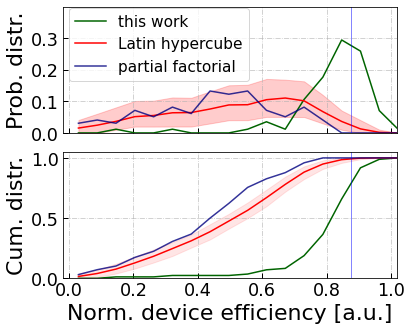

In [128]:
norm_factor = max(thiswork_effmax_seq)
x_norm = x/norm_factor
fig,axes = plt.subplots(2, 1, figsize=(6, 5), sharex = True)
fs = 22
ax = axes[0]
# ax.plot(x, random_distr_mean, color = 'navy') 
# ax.fill_between(x, random_distr_min, random_distr_max, alpha = 0.2, color = 'navy')

ax.plot(x_norm, thiswork_distr, color = 'darkgreen', label = 'this work') 
#ax.scatter(x, thiswork_distr, color = 'darkgreen') 

ax.plot(x_norm, lhs_distr_mean, color = 'red', label = 'Latin hypercube') 
#ax.scatter(x, lhs_distr_mean, color = 'red') 
ax.fill_between(x_norm, lhs_distr_min, lhs_distr_max, alpha = 0.2, color = 'red')

ax.plot(x_norm, partialgrid_distr, color = 'navy', linewidth = 1.5, alpha = 0.8, label = 'partial factorial') 
#ax.scatter(x, partialgrid_distr, color = 'navy') 
ax.plot(np.ones(100)*15/norm_factor, np.linspace(0, 2,100), color = 'blue', alpha = 0.6, linewidth = 0.8) 
#ax.plot(np.ones(100)*16.8/norm_factor, np.linspace(0, 2,100), color = 'black', alpha = 0.7, linewidth = 0.8) 


ax.set_ylabel('Prob. distr.', fontsize = fs)
ax.set_ylim(0, 0.4)
ax.set_yticks([0, 0.1, 0.2, 0.3])

ax.set_xlim(-0.02, 1.02)

 

ax = axes[1]

# ax.plot(x, random_cum_distr_mean, color = 'navy') 
# ax.fill_between(x, random_cum_distr_min, random_cum_distr_max, alpha = 0.2, color = 'navy')

ax.plot(x_norm, thiswork_cum, color = 'darkgreen', label = 'this work') 
#ax.scatter(x, thiswork_cum, color = 'darkgreen') 

ax.plot(x_norm, lhs_cum_distr_mean, color = 'red', label = 'Latin hypercube')
#ax.scatter(x, lhs_cum_distr_mean, color = 'red')
ax.fill_between(x_norm, lhs_cum_distr_min, lhs_cum_distr_max, alpha = 0.1, color = 'red')

ax.plot(x_norm, partialgrid_cum, color = 'navy', linewidth = 1.5, alpha = 0.8, label = 'partial factorial') 
#ax.scatter(x, partialgrid_cum, color = 'navy') 
ax.plot(np.ones(100)*15/norm_factor, np.linspace(0, 2,100), color = 'blue', alpha = 0.6, linewidth = 0.8) 
#ax.plot(np.ones(100)*16.8/norm_factor, np.linspace(0, 2,100), color = 'black', alpha = 0.7, linewidth = 0.8) 


ax.set_ylabel('Cum. distr.', fontsize = fs)
ax.set_xlabel('Norm. device efficiency [a.u.]', fontsize = fs)
ax.set_yticks([0, 0.5, 1.0])

ax.set_ylim(0, 1.05)
ax.set_xlim(-0.02, 1.02)
ax.legend(bbox_to_anchor=(0.08, 1.3, 0.5, 0.9), fontsize = fs*0.7)

for ax in axes:
    ax.tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.7)
    ax.grid(True, linestyle='-.')
plt.subplots_adjust(hspace = 0.15)
plt.show()

In [129]:
# design = RandomDesign(parameter_space)
# random_cnt_list = []
# random_cum_list = []
# random_effmax_seq_list = []
# for i in np.arange(200):
#     design = RandomDesign(parameter_space)
#     x_random = design.get_samples(1000)
#     #x_random_original = get_closest_array(x_denormalizer(x_random))
#     x_random_original = x_denormalizer(x_random)
#     df_random = pd.DataFrame(x_random_original, columns = x_labels)
#     y_pred_random = scaler_y.inverse_transform(GBregressor.predict(scaler.transform(x_random_original)))
#     df_random['Efficiency [%]'] = np.around(y_pred_random, 2)
    
#     eff_seq= df_random.iloc[:,-1].values
#     eff_sorted = np.sort(eff_seq)
#     effmax_seq = np.maximum.accumulate(eff_seq)

#     cnts, bins = np.histogram(eff_sorted, bins=np.arange(21))
#     cum_cnts = np.cumsum(cnts)
#     x = bins[:-1]+0.5
#     y_cnt = cnts/cum_cnts[-1]
#     y_cum = cum_cnts/cum_cnts[-1]
#     random_cnt_list.append(y_cnt)
#     random_cum_list.append(y_cum)
#     random_effmax_seq_list.append(effmax_seq)
    
# random_effmax_seq_max = np.quantile(random_effmax_seq_list, 0.975, axis = 0)
# random_effmax_seq_min = np.quantile(random_effmax_seq_list, 0.025, axis = 0)
# random_effmax_seq_mean = np.mean(random_effmax_seq_list, axis = 0)

# random_distr_max = np.quantile(random_cnt_list, 0.975, axis = 0)
# random_distr_min = np.quantile(random_cnt_list, 0.025, axis = 0)
# random_distr_mean = np.mean(random_cnt_list, axis = 0)
    
# random_cum_distr_max = np.quantile(random_cum_list, 0.975, axis = 0)
# random_cum_distr_min = np.quantile(random_cum_list, 0.025, axis = 0)
# random_cum_distr_mean = np.mean(random_cum_list, axis = 0)

lhs_cum_list = []
lhs_cnt_list = []
lhs_effmax_seq_list = []
for i in np.arange(500):
    design = LatinDesign(parameter_space)
    x_LHS = design.get_samples(500)
    #x_LHS_original = get_closest_array(x_denormalizer(x_LHS))
    x_LHS_original = x_denormalizer(x_LHS)
    df_LHS = pd.DataFrame(x_LHS_original, columns = x_labels)

    y_pred_LHS = scaler_y.inverse_transform(GBregressor.predict(scaler.transform(x_LHS_original)))
    df_LHS['Efficiency [%]'] = np.around(y_pred_LHS, 2) 
    
    eff_seq= df_LHS.iloc[:,-1].values
    effmax_seq = np.maximum.accumulate(eff_seq)

    eff_sorted = np.sort(eff_seq)
    cnts, bins = np.histogram(eff_sorted, bins=np.arange(21))
    cum_cnts = np.cumsum(cnts)
    x = bins[:-1]+0.5
    y_cnt = cnts/cum_cnts[-1]
    y_cum = cum_cnts/cum_cnts[-1]
    lhs_cnt_list.append(y_cnt)
    lhs_cum_list.append(y_cum)
    lhs_effmax_seq_list.append(effmax_seq)
    
lhs_effmax_seq_max = np.quantile(lhs_effmax_seq_list, 0.975, axis = 0)
lhs_effmax_seq_min = np.quantile(lhs_effmax_seq_list, 0.025, axis = 0)
lhs_effmax_seq_mean = np.mean(lhs_effmax_seq_list, axis = 0)

lhs_distr_max = np.quantile(lhs_cnt_list, 0.975, axis = 0)
lhs_distr_min = np.quantile(lhs_cnt_list, 0.025, axis = 0)
lhs_distr_mean = np.mean(lhs_cnt_list, axis = 0)

lhs_cum_distr_max = np.quantile(lhs_cum_list, 0.975, axis = 0)
lhs_cum_distr_min = np.quantile(lhs_cum_list, 0.025, axis = 0)
lhs_cum_distr_mean = np.mean(lhs_cum_list, axis = 0)


eff_seq= df_thiswork_device.iloc[:,-1].values
eff_sorted = np.sort(eff_seq)
thiswork_effmax_seq = np.maximum.accumulate(eff_seq)
cnts, bins = np.histogram(eff_sorted, bins=np.arange(21))
cum_cnts = np.cumsum(cnts)
x = bins[:-1]+0.5
thiswork_distr = cnts/cum_cnts[-1]
thiswork_cum = cum_cnts/cum_cnts[-1]


eff_seq= df_grid.iloc[:,-1].values
fullgrid_effmax_seq = np.maximum.accumulate(eff_seq)
eff_sorted = np.sort(eff_seq)
cnts, bins = np.histogram(eff_sorted, bins=np.arange(21))
cum_cnts = np.cumsum(cnts)
x = bins[:-1]+0.5
fullgrid_distr = cnts/cum_cnts[-1]
fullgrid_cum = cum_cnts/cum_cnts[-1]


eff_seq= df_grid.iloc[:,-1].values
partialgrid_effmax_seq = np.maximum.accumulate(eff_seq)
eff_sorted = np.sort(eff_seq)
cnts, bins = np.histogram(eff_sorted, bins=np.arange(21))
cum_cnts = np.cumsum(cnts)
x = bins[:-1]+0.5
partialgrid_distr = cnts/cum_cnts[-1]
partialgrid_cum = cum_cnts/cum_cnts[-1]

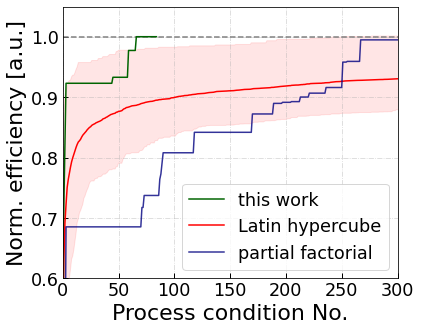

In [134]:
fig,axes = plt.subplots(1, 1, figsize=(6, 5), sharex = False)
fs = 22
ax = axes

ax.plot(np.arange(500), np.arange(500)*0+1, '--', color = 'gray')

# ax.plot(np.arange(len(random_effmax_seq_mean)), random_effmax_seq_mean, color = 'navy') 
# ax.fill_between(np.arange(len(random_effmax_seq_mean)), random_effmax_seq_min, random_effmax_seq_max, alpha = 0.2, color = 'navy')
norm_factor = max(thiswork_effmax_seq)

ax.plot(np.arange(len(thiswork_effmax_seq)), thiswork_effmax_seq/norm_factor,
        color = 'darkgreen', label = 'this work') 

ax.plot(np.arange(len(lhs_effmax_seq_mean)), lhs_effmax_seq_mean/norm_factor,
        color = 'red', label = 'Latin hypercube') 
ax.fill_between(np.arange(len(lhs_effmax_seq_mean)), 
                lhs_effmax_seq_min/norm_factor, lhs_effmax_seq_max/norm_factor,
                alpha = 0.1, color = 'red')
ax.plot(np.arange(len(partialgrid_effmax_seq)), partialgrid_effmax_seq/norm_factor,
        color = 'navy', linewidth = 1.5, alpha = 0.8, label = 'partial factorial') 

ax.set_xlabel('Process condition No.', fontsize = fs)
ax.set_ylabel('Norm. efficiency [a.u.]', fontsize = fs)
ax.set_ylim(0.6, 1.05)
ax.set_xlim(0, 300)
ax.legend(loc = 'lower right', fontsize = fs*0.8)

ax.tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
ax.grid(True, linestyle='-.')
plt.subplots_adjust(hspace = 0.35)
plt.show()


In [210]:
pGrid_list_df = pd.DataFrame(np.transpose(df_grid.iloc[:,-1]))
pGrid_list_df
#pGrid_list_df.to_excel("partGrid_benckmark.xls")